In [2]:
!pip install LightPipes[pyfftw]
from LightPipes import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 929.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 8.5 MB/s eta 0:00:00


Vamos criar o feixe GSM com a decomposição em pseudos modos, como apresentado no scripts anteriores.

In [22]:
lambd = 780*nm;
sigma = .2*mm; # cintura do feixe
delta = .1*mm; # coherence length

N  = 2**7;
dx = 10*um;
x  = np.arange(-N/2,N/2,1)*dx;
[xx,yy] = np.meshgrid(x,x);

L = 300; # Número da soma incorente
L_nm = 25; # #Numero da soma corent

para simular com  L>=200  eL_nm=25 a simulação fica bem demorada. Irei sugerir algumas melhoras :

In [23]:
v_x = np.linspace(-1,1,L_nm)*np.sqrt(2)/(np.pi*delta )
v_n, v_m =  np.meshgrid(v_x,v_x)

p_nm = np.exp( - (v_n**2 + v_m**2)*( np.pi*delta )**2)

Hxy  = np.exp(-( xx**2 + yy**2 )/(2*sigma )**2)
H_pnm = np.exp(2j*np.pi*( np.tensordot(xx,v_n,axes=0) + np.tensordot(yy,v_m,axes=0)) )

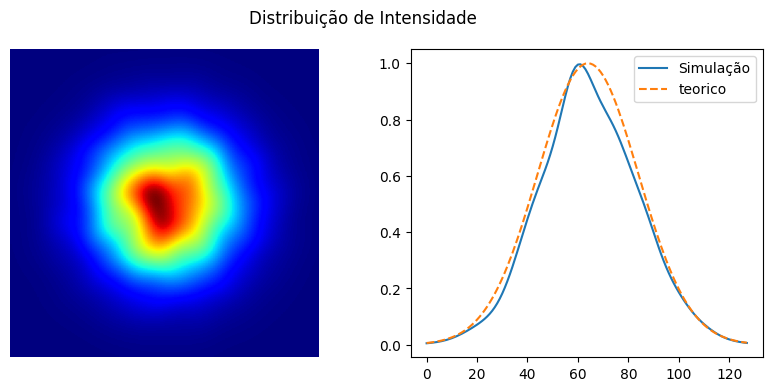

In [24]:
#-------------------------------------
v_x = np.linspace(-1,1,L_nm)*np.sqrt(2)/(np.pi*delta )
pseudos_modos = np.exp(1j*np.zeros((N,N,L)))

# Soma incoerente
for ii in range(0,L):
    # Soma coerente
    u = np.zeros_like(xx);
    for j in range(L_nm): # v_n
        for i in range(L_nm): # v_m
            random_phase = np.exp(- 2j*np.pi*np.random.randn(1) )
            campo = (np.sqrt( 2*np.pi )*delta )*p_nm[i,j]*Hxy*H_pnm[:,:,i,j]*random_phase
            u = u + campo

    # Salavando e normalization
    pseudos_modos[:,:,ii] = u/u.max();


#### Visualizando a intensidade do feixe #######
# Expressão teorica para comparar
teorico = np.exp(-x**2/(2*sigma**2) )

u = np.sum(abs(pseudos_modos**2),2) # Intensidade
u = u/u.max() # Normalizando

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
fig.suptitle('Distribuição de Intensidade')

ax1.imshow(u,cmap="jet")
ax1.set_axis_off()

ax2.plot(u[N//2,:],label="Simulação")
ax2.plot(teorico,"--" ,label="teorico")
plt.legend()
plt.show()


Essa parte é dedicada para criar a fenda e em seguida proparar o campo.
Para realizar a propagaçaõ usaremos as funçções do Lightpipes.

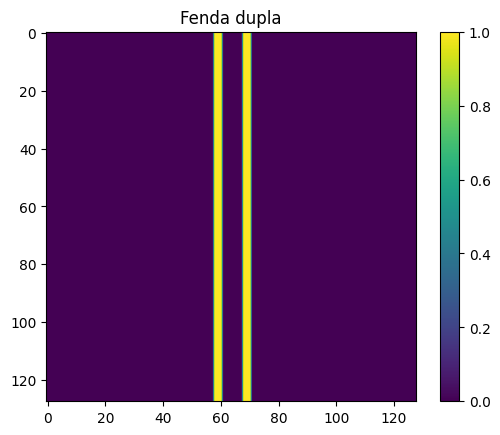

In [25]:
d0 = .1*mm; # Distância entre as fendas
a0 = .03*mm; # Tamanho entre as fendas

# make slit
fslit = (np.ones_like(xx)*(abs(xx+(d0/2))<=a0/2) +
         np.ones_like(xx)*(abs(xx-(d0/2))<=a0/2));
# show slit
plt.imshow(fslit); plt.title('Fenda dupla')
plt.colorbar();plt.show()

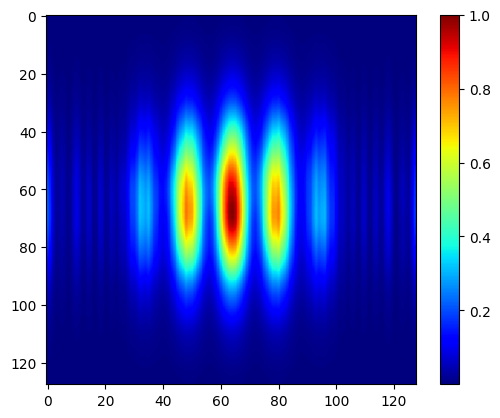

In [26]:
# Primeiro criando uma variavel para colcoar os campo criado anteriormente

F  = Begin(abs(x[0])*2,lambd,N )

imagem =[0]
FF = F.copy(F)

# estamos criando um loop para passar cada pseudo modo por vez.
for i in range(L):
    # multiplicamos cada modo pela fenda
    FF.field = pseudos_modos[:,:,i]*fslit
    # em seguida iremos proparagar o campo por uma distancia de 1.5cm
    FF1      = Forvard(2.0*cm,FF)

    # agora itemos armazenar a intensidade
    imagem   += Intensity(FF1)

# visualizando os resultados
imagem = imagem/imagem.max()
plt.imshow(imagem,cmap = "jet");plt.colorbar();plt.show()

Determinando todos os máximos e mínimos

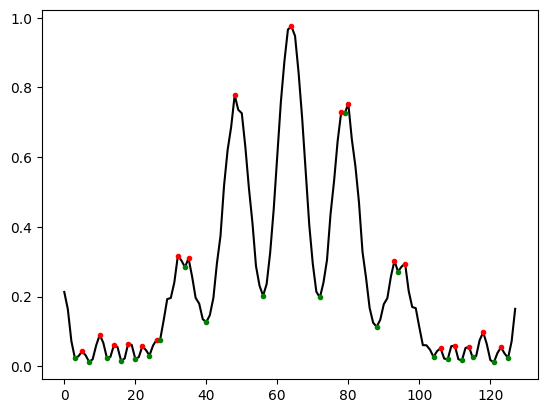

In [28]:
from scipy.signal import argrelextrema
# Pegando apenas o centro da imagem
frajas= imagem[N//2,:]
# Determinado todos os máximo e mínimos
maximos = argrelextrema(frajas, np.greater)
minimos = argrelextrema(frajas, np.less)

plt.plot(frajas,"k")
plt.plot(maximos[0], frajas[maximos],"r.")
plt.plot(minimos[0], frajas[minimos],"g.")

plt.show()

O maximo absoluto

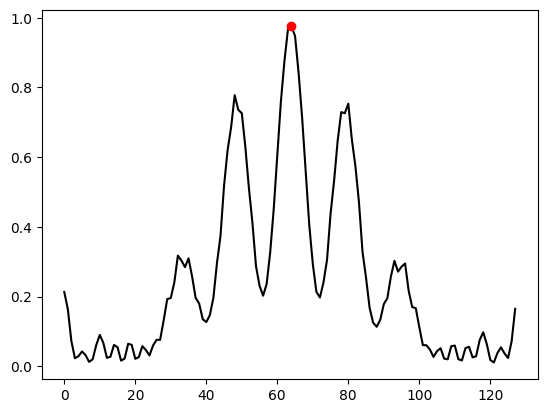

In [29]:
maximo_valor = frajas[maximos].max()
maximo_index = np.where( frajas == frajas[maximos].max())

plt.plot(frajas,"k")
plt.plot(maximo_index, maximo_valor,"ro")
plt.show()

Vamos definir uma função para encontrar o indice do primeiro minimo a parti do indice do valor maximo

In [30]:
def primeiro_maior(lista, valor):
    for i in lista:
        if i > valor:
            return i
    return None

In [31]:
# sabemos que a lista de minimo é
print(minimos[0], "- indice do valor maximo:",maximo_index[0][0] )

[  3   7  12  16  20  24  27  34  40  56  72  79  88  94 104 108 112 115
 121 125] - indice do valor maximo: 64


podemos ver que o primeior mínimo apos o máximo

In [32]:
minimo_index = primeiro_maior(minimos[0],maximo_index[0][0])
print(" Indice do primeiro minimo:",minimo_index,"\n Valor primeiro minimo:",frajas[minimo_index])

 Indice do primeiro minimo: 72 
 Valor primeiro minimo: 0.19761445009065096


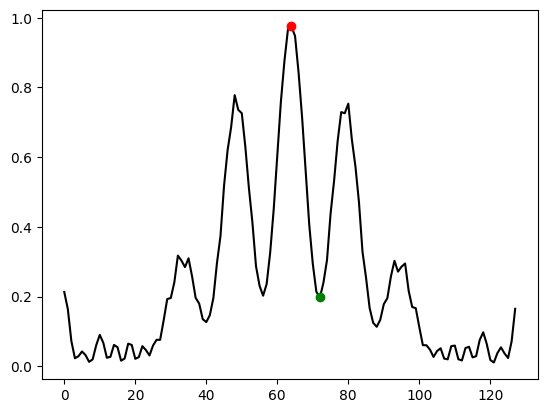

In [33]:
minimo_valor = frajas[minimo_index]

plt.plot(frajas,"k")
plt.plot(maximo_index, maximo_valor,"ro")
plt.plot(minimo_index, minimo_valor,"go")
plt.show()

Vamos calcular a visibilidade

In [34]:
V = ( maximo_valor - minimo_valor)/( maximo_valor + minimo_valor)
V

0.6629138984507302

Essa visibilidade é apenas para a regiao com y = N/2.

É interessante fazer a media de alguns pontos da regiao central

In [35]:
VisibilidadeN =0
V_plot = []
count = 0
for i in  range(N//2 - 50,N//2 + 50):
    # Pegando apenas o centro da imagem
    frajas= imagem[i,:]
    # Determinado todos os máximo e mínimos
    maximos = argrelextrema(frajas, np.greater)
    minimos = argrelextrema(frajas, np.less)
    # valor do máximo
    maximo_valor = frajas[maximos].max()
    # indice do máximo
    maximo_index = np.where( frajas == frajas[maximos].max())
    # indice de 1° minimo
    minimo_index = primeiro_maior(minimos[0],maximo_index[0][0])
    # valor de 1° minimo
    minimo_valor = frajas[minimo_index]
    V = ( maximo_valor - minimo_valor)/( maximo_valor + minimo_valor)
    VisibilidadeN += V
    V_plot.append(V)
    count+=1

print("Valor medio da grau de coerencia/Visibilidade ",VisibilidadeN/count)

Valor medio da grau de coerencia/Visibilidade  0.6473230024736217


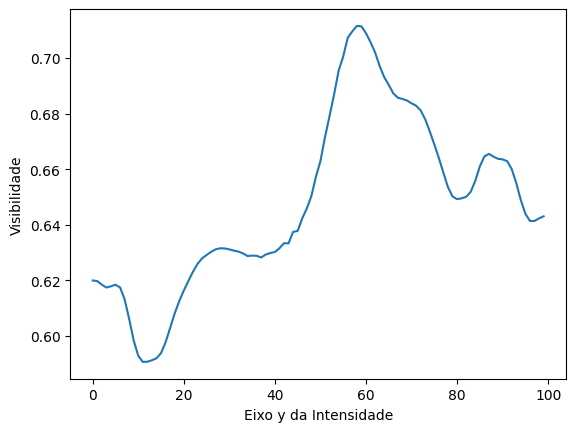

In [36]:
plt.plot(V_plot)
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()